In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import copy
import time

import sys
sys.path.append('../../')

from data.processing import get_data

import models

from main.seir.fitting import single_fitting_cycle
from main.seir.forecast import get_forecast, forecast_all_trials, create_all_trials_csv, create_decile_csv_new, predict_r0_multipliers, save_r0_mul
from main.seir.sensitivity import calculate_sensitivity_and_plot
from utils.generic.create_report import save_dict_and_create_report
from utils.generic.config import read_config
from utils.generic.enums import Columns
from utils.fitting.loss import Loss_Calculator
#from utils.generic.logging import log_wandb
from viz import plot_forecast, plot_top_k_trials, plot_ptiles, plot_r0_multipliers

import yaml

In [9]:
predictions_dict = {}

In [10]:
config_filename = 'bokaro.yaml'
config = read_config(config_filename)

In [11]:
output_folder = '../../misc/reports/{}'.format(datetime.datetime.now().strftime("%Y_%m%d_%H%M%S"))

## Perform M1 and M2 fits

Performing m1 fit ..
pulling from cache
pulling from source
splitting data ..
splitting data ..
          date      state district  total  active  recovered  deceased  \
0   2020-04-27  Jharkhand   Bokaro     10       5          4         1   
1   2020-04-28  Jharkhand   Bokaro     10       5          4         1   
2   2020-04-29  Jharkhand   Bokaro     10       5          4         1   
3   2020-04-30  Jharkhand   Bokaro     10       5          4         1   
4   2020-05-01  Jharkhand   Bokaro     10       3          6         1   
..         ...        ...      ...    ...     ...        ...       ...   
178 2020-10-22  Jharkhand   Bokaro   5028     314       4669        45   
179 2020-10-23  Jharkhand   Bokaro   5093     352       4696        45   
180 2020-10-24  Jharkhand   Bokaro   5133     363       4725        45   
181 2020-10-25  Jharkhand   Bokaro   5182     377       4760        45   
182 2020-10-26  Jharkhand   Bokaro   5209     339       4825        45   

      tested  o

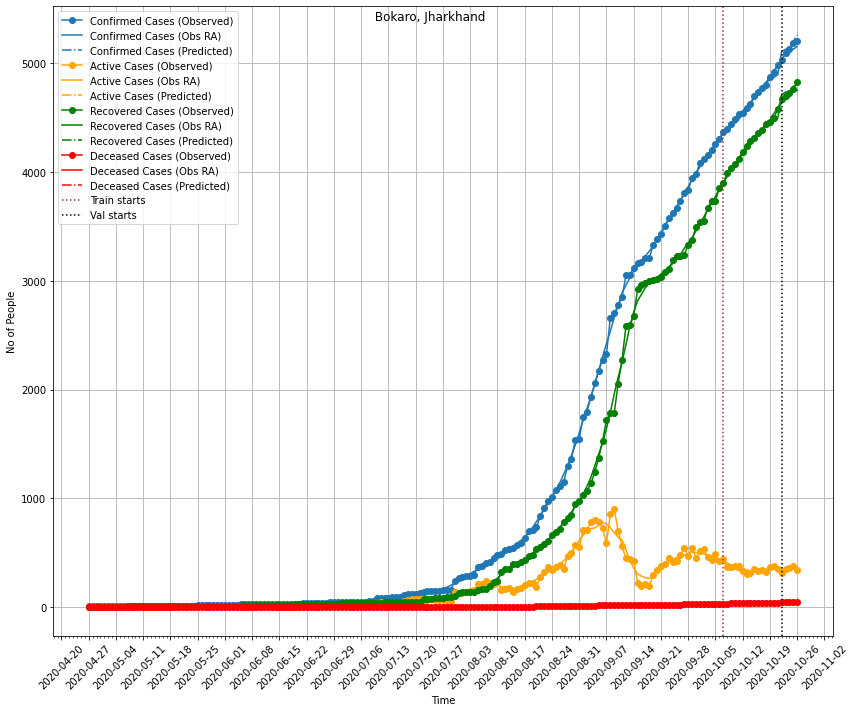

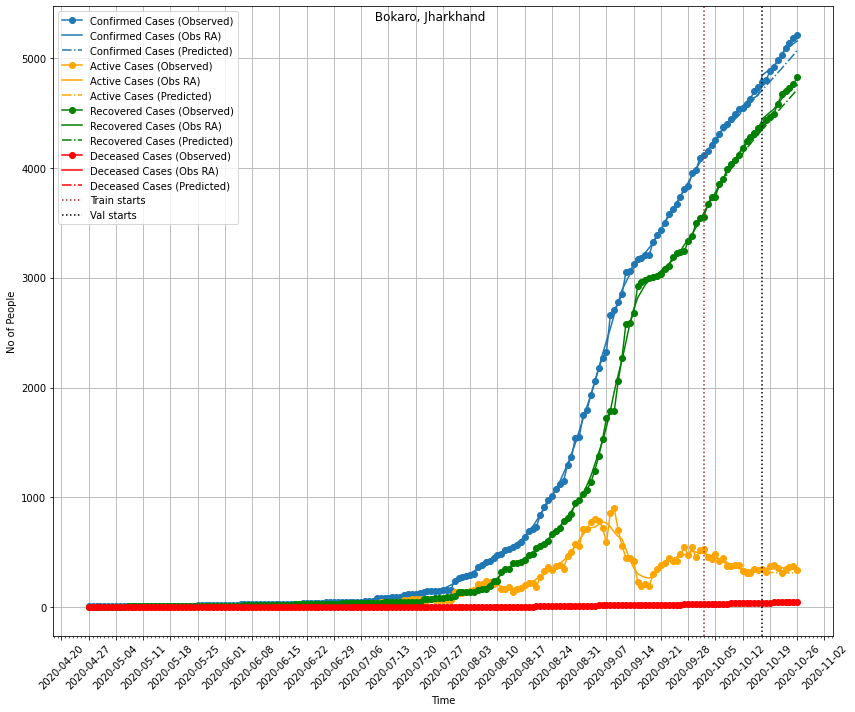

In [12]:
predictions_dict['m1'] = single_fitting_cycle(**copy.deepcopy(config['fitting'])) 

m2_params = copy.deepcopy(config['fitting'])
m2_params['split']['val_period'] = 10
m2_params['split']['test_period'] = 0
predictions_dict['m2'] = single_fitting_cycle(**m2_params)
# predictions_dict['m2'] = predictions_dict['m1']

predictions_dict['fitting_date'] = datetime.datetime.now().strftime("%Y-%m-%d")

In [13]:
predictions_dict['m1']['best_params']

{'E_hosp_ratio': 0.7602659595630259,
 'I_hosp_ratio': 0.15018841947766742,
 'P_fatal': 0.0464363373327848,
 'T_inc': 4.317874818923859,
 'T_inf': 3.820883359162648,
 'T_recov': 6.5321173664937735,
 'T_recov_fatal': 31.57043427311541,
 'lockdown_R0': 1.112316766752346}

In [14]:
predictions_dict['m2']['best_params']

{'E_hosp_ratio': 0.17201693011748534,
 'I_hosp_ratio': 0.42307756815160397,
 'P_fatal': 0.02029795606739286,
 'T_inc': 4.742696227747982,
 'T_inf': 3.533339446456747,
 'T_recov': 7.40488214266171,
 'T_recov_fatal': 26.01499437343825,
 'lockdown_R0': 1.0583034425160804}

## Loss Dataframes

### M1 Loss DataFrame

In [15]:
predictions_dict['m1']['df_loss']

train       val
total      0.205624  0.367162
active      16.1172   5.72827
recovered   2.83389  0.368593
deceased    21.8471   5.77778

### M2 Loss DataFrame

In [16]:
predictions_dict['m2']['df_loss']

train      val
total      0.399829  2.64143
active      12.9965  20.4442
recovered   5.58351   4.4043
deceased     21.969  55.3405

## Sensitivity Plot

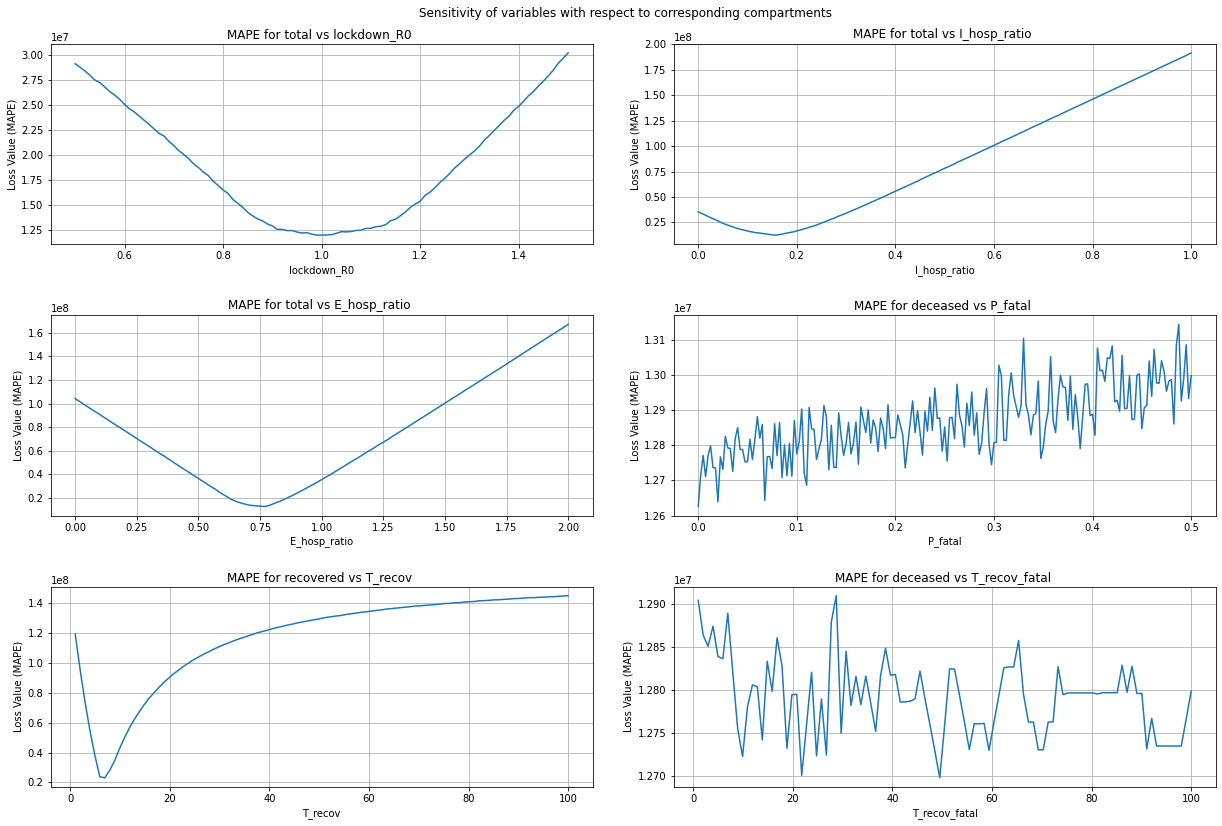

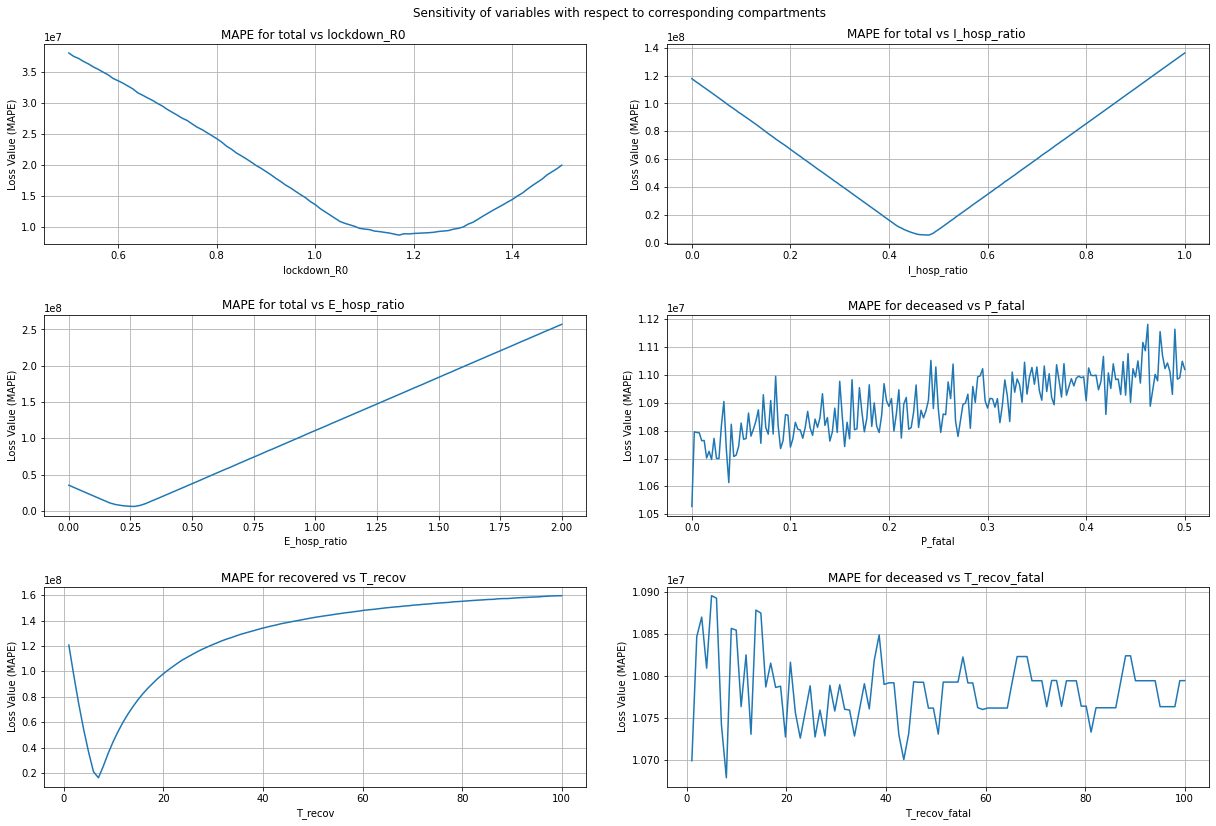

In [17]:
predictions_dict['m1']['plots']['sensitivity'], _, _ = calculate_sensitivity_and_plot(predictions_dict, config, which_fit='m1')
predictions_dict['m2']['plots']['sensitivity'], _, _ = calculate_sensitivity_and_plot(predictions_dict, config, which_fit='m2')

## Plot Forecasts

In [18]:
# M2 based forecasting for the next train_period + test_period + forecast_period (no validation period)
predictions_dict['m2']['forecasts'] = {}
predictions_dict['m2']['forecasts']['best'] = get_forecast(predictions_dict, train_fit='m2', 
                                                           model=config['fitting']['model'], 
                                                           days=config['forecast']['forecast_days'])

getting forecasts ..


[         date        S    E    I  R_recov  R_fatal     C   D  active  \
0  2020-10-02  3295600   84  207      480        9  3586  30     489   
1  2020-10-03  3295543  119  175      469       10  3651  30     479   
2  2020-10-04  3295494  141  156      452       11  3713  31     463   
3  2020-10-05  3295449  154  145      434       11  3773  31     445   
4  2020-10-06  3295406  163  138      416       11  3830  32     427   
..        ...      ...  ...  ...      ...      ...   ...  ..     ...   
65 2020-12-06  3292524  263  192      375       24  6543  75     399   
66 2020-12-07  3292467  265  193      378       24  6594  76     402   
67 2020-12-08  3292409  267  194      380       24  6645  77     404   
68 2020-12-09  3292350  269  195      383       24  6697  78     407   
69 2020-12-10  3292292  271  197      386       24  6749  79     410   

    recovered  deceased  total  
0        3586        30   4105  
1        3651        30   4160  
2        3713        31   4207  
3 

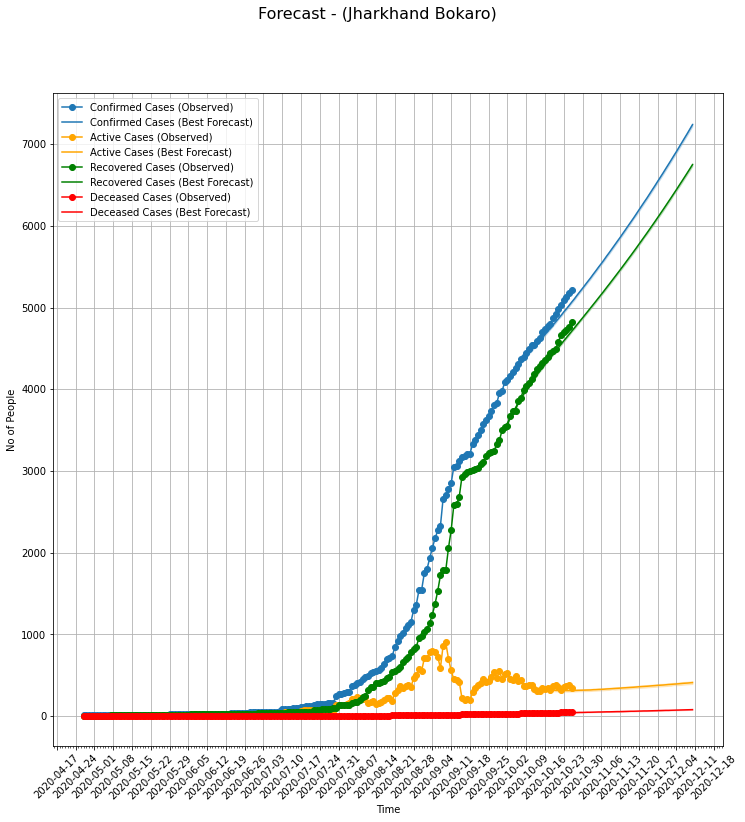

In [19]:
# Predictions plotted are for the most recent train_period days + test_period + forecast_period (no validation_period)
predictions_dict['m2']['plots']['forecast_best'] = plot_forecast(predictions_dict, 
                                                                 (config['fitting']['data']['dataloading_params']['state'], 
                                                                  config['fitting']['data']['dataloading_params']['district']), 
                                                                 error_bars=True)

In [20]:
predictions_dict['m1']['trials_processed'] = forecast_all_trials(predictions_dict, train_fit='m1', 
                                                                 model=config['fitting']['model'], 
                                                                 forecast_days=config['forecast']['forecast_days'])

6it [00:00, 51.12it/s]getting forecasts ..
1000it [00:23, 42.00it/s]


In [21]:
predictions_dict['m2']['trials_processed'] = forecast_all_trials(predictions_dict, train_fit='m2', 
                                                                 model=config['fitting']['model'], 
                                                                 forecast_days=config['forecast']['forecast_days'])

3it [00:00, 29.56it/s]getting forecasts ..
1000it [00:21, 46.03it/s]


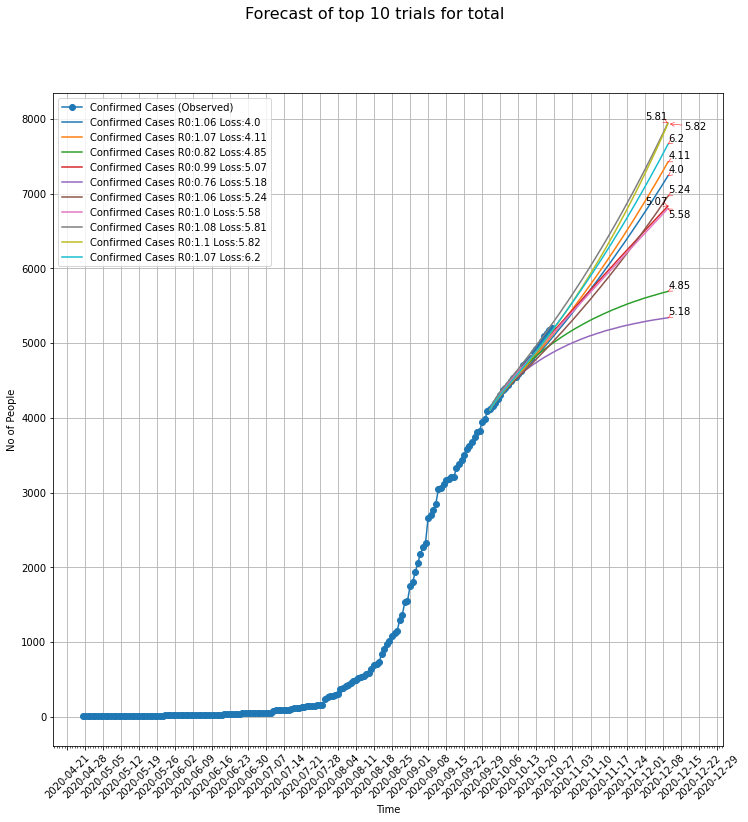

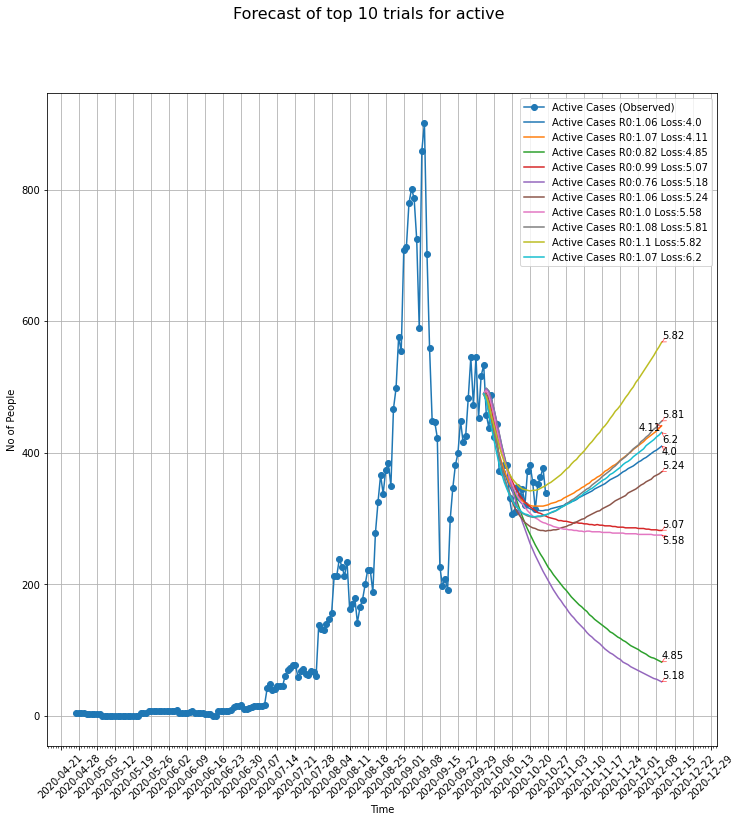

In [22]:
kforecasts = plot_top_k_trials(predictions_dict, train_fit='m2',
                               k=config['forecast']['num_trials_to_plot'],
                               which_compartments=config['forecast']['plot_topk_trials_for_columns'])

In [23]:
predictions_dict['m2']['plots']['forecasts_topk'] = {}
for column in config['forecast']['plot_topk_trials_for_columns']:
    predictions_dict['m2']['plots']['forecasts_topk'][column.name] = kforecasts[column]

## Uncertainty + Uncertainty Forecasts

In [24]:
uncertainty_args = {'predictions_dict': predictions_dict, **config['uncertainty']['uncertainty_params']}
uncertainty = config['uncertainty']['method'](**uncertainty_args)

100%|██████████| 100/100 [01:38<00:00,  1.02trial/s, best loss: 3.2636256655895926]


In [25]:
uncertainty.beta_loss

{'active': 6.423702945884631,
 'recovered': 0.5693994500206419,
 'deceased': 5.777780582176253,
 'total': 0.2836196842768449}

In [26]:
uncertainty_forecasts = uncertainty.get_forecasts()
for key in uncertainty_forecasts.keys():
    predictions_dict['m2']['forecasts'][key] = uncertainty_forecasts[key]['df_prediction']
    
predictions_dict['m2']['forecasts']['ensemble_mean'] = uncertainty.ensemble_mean_forecast

In [27]:
predictions_dict['m2']['beta'] = uncertainty.beta
predictions_dict['m2']['beta_loss'] = uncertainty.beta_loss
predictions_dict['m2']['deciles'] = uncertainty_forecasts

[         date        S    E    I  R_recov  R_fatal     C   D  active  \
0  2020-10-02  3295600   84  207      480        9  3586  30     489   
1  2020-10-03  3295543  119  175      469       10  3651  30     479   
2  2020-10-04  3295494  141  156      452       11  3713  31     463   
3  2020-10-05  3295449  154  145      434       11  3773  31     445   
4  2020-10-06  3295406  163  138      416       11  3830  32     427   
..        ...      ...  ...  ...      ...      ...   ...  ..     ...   
65 2020-12-06  3292524  263  192      375       24  6543  75     399   
66 2020-12-07  3292467  265  193      378       24  6594  76     402   
67 2020-12-08  3292409  267  194      380       24  6645  77     404   
68 2020-12-09  3292350  269  195      383       24  6697  78     407   
69 2020-12-10  3292292  271  197      386       24  6749  79     410   

    recovered  deceased  total  
0        3586        30   4105  
1        3651        30   4160  
2        3713        31   4207  
3 

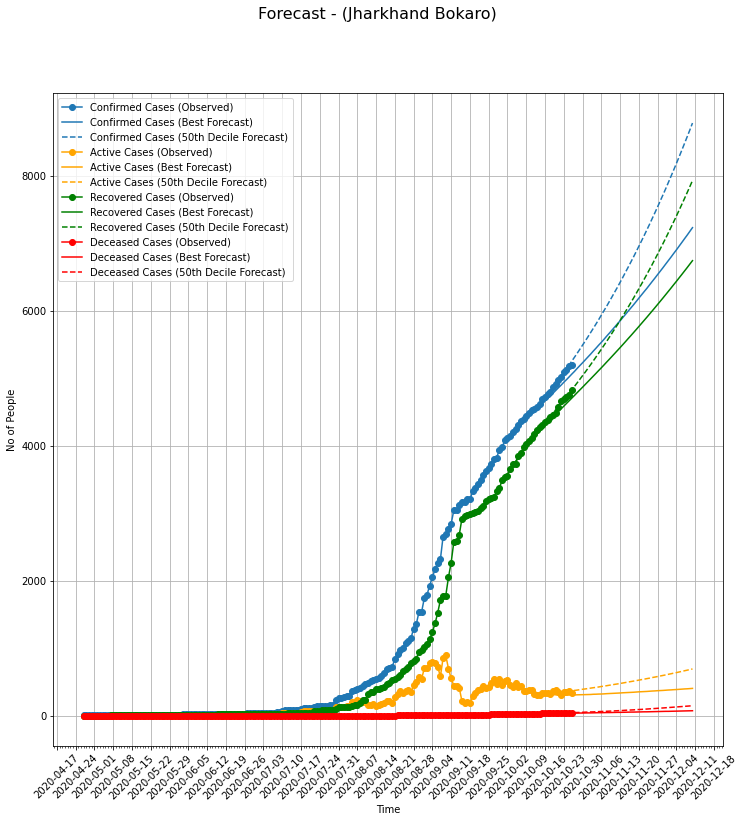

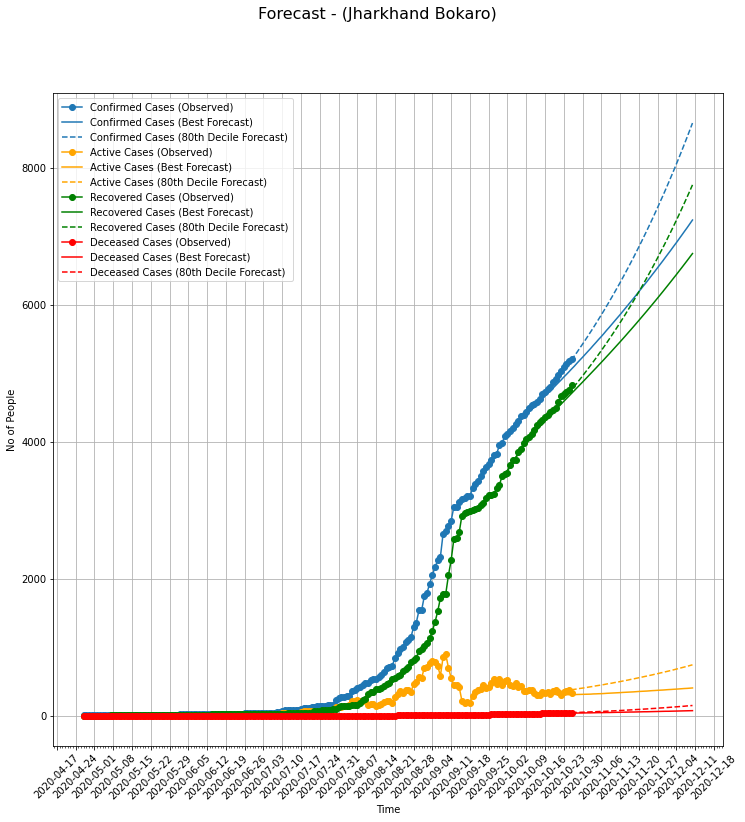

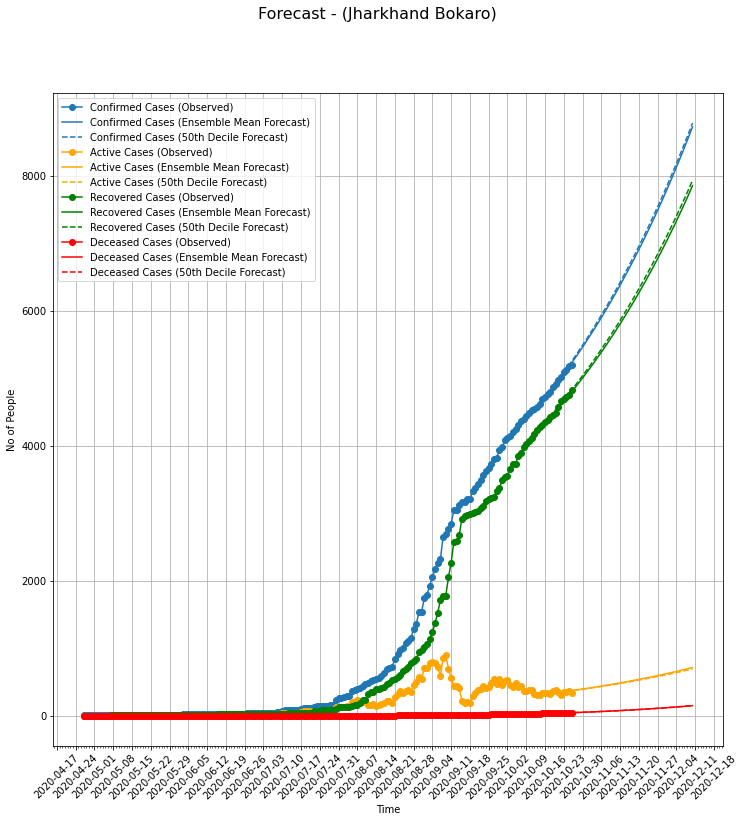

In [28]:
predictions_dict['m2']['plots']['forecast_best_50'] = plot_forecast(predictions_dict, 
                                                                    (config['fitting']['data']['dataloading_params']['state'], 
                                                                     config['fitting']['data']['dataloading_params']['district']),
                                                                    fits_to_plot=['best', 50], error_bars=False)
predictions_dict['m2']['plots']['forecast_best_80'] = plot_forecast(predictions_dict, 
                                                                    (config['fitting']['data']['dataloading_params']['state'], 
                                                                     config['fitting']['data']['dataloading_params']['district']),
                                                                    fits_to_plot=['best', 80], error_bars=False)
predictions_dict['m2']['plots']['forecast_ensemble_mean_50'] = plot_forecast(predictions_dict, 
                                                                             (config['fitting']['data']['dataloading_params']['state'], 
                                                                              config['fitting']['data']['dataloading_params']['district']),
                                                                             fits_to_plot=['ensemble_mean', 50], error_bars=False)

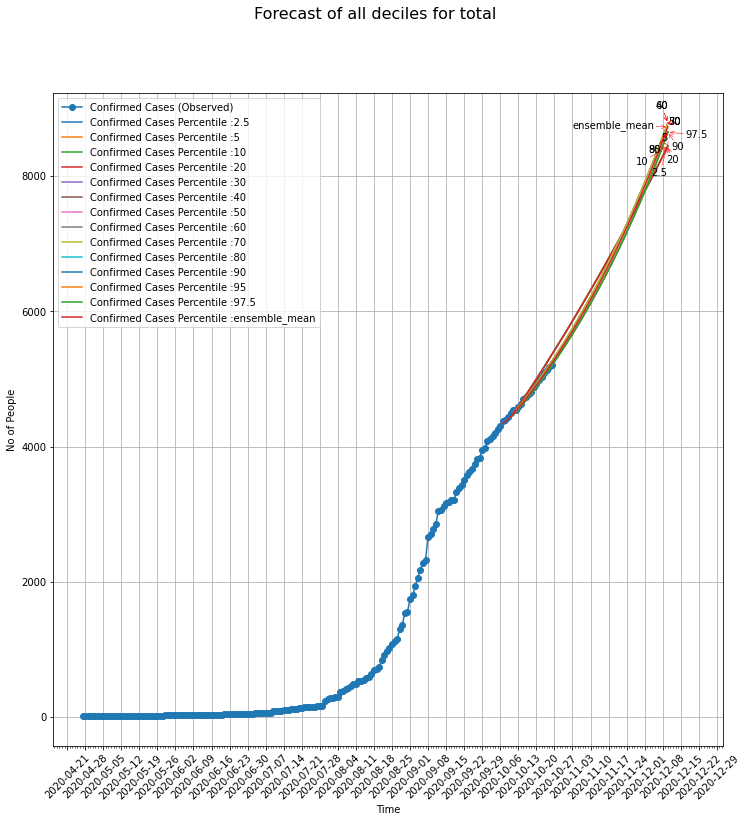

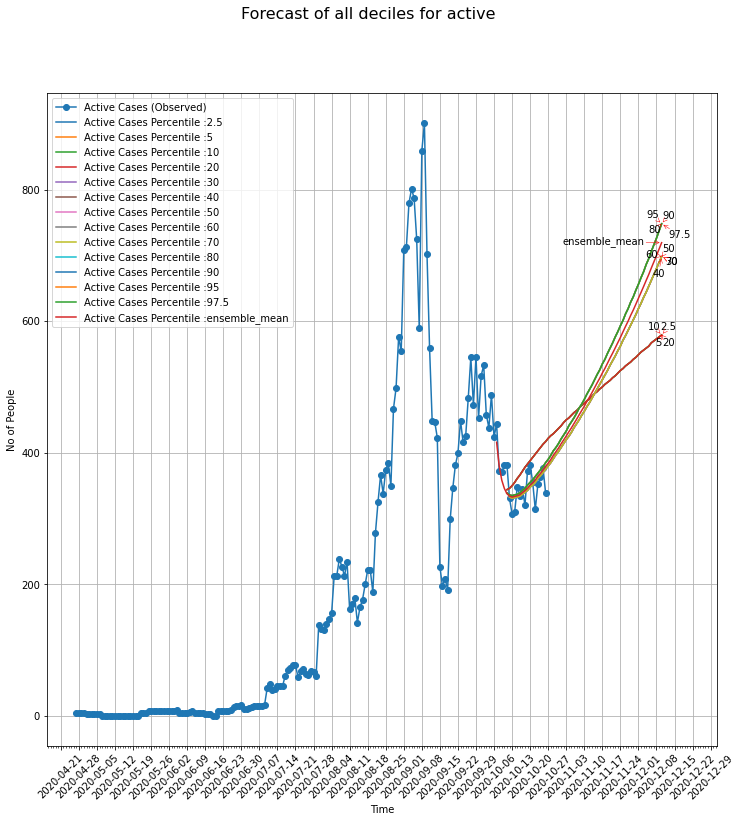

In [29]:
ptiles_plots = plot_ptiles(predictions_dict, which_compartments=config['forecast']['plot_ptiles_for_columns'])
predictions_dict['m2']['plots']['forecasts_ptiles'] = {}
for column in config['forecast']['plot_ptiles_for_columns']:
    predictions_dict['m2']['plots']['forecasts_ptiles'][column.name] = ptiles_plots[column]

## What If Scenarios - R0 Multipliers

getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..


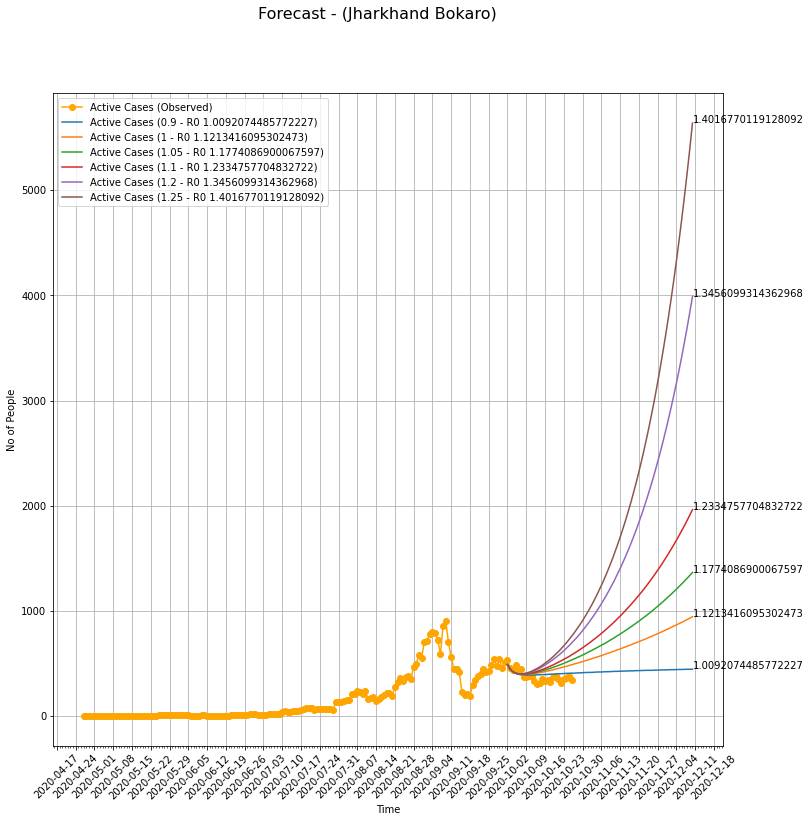

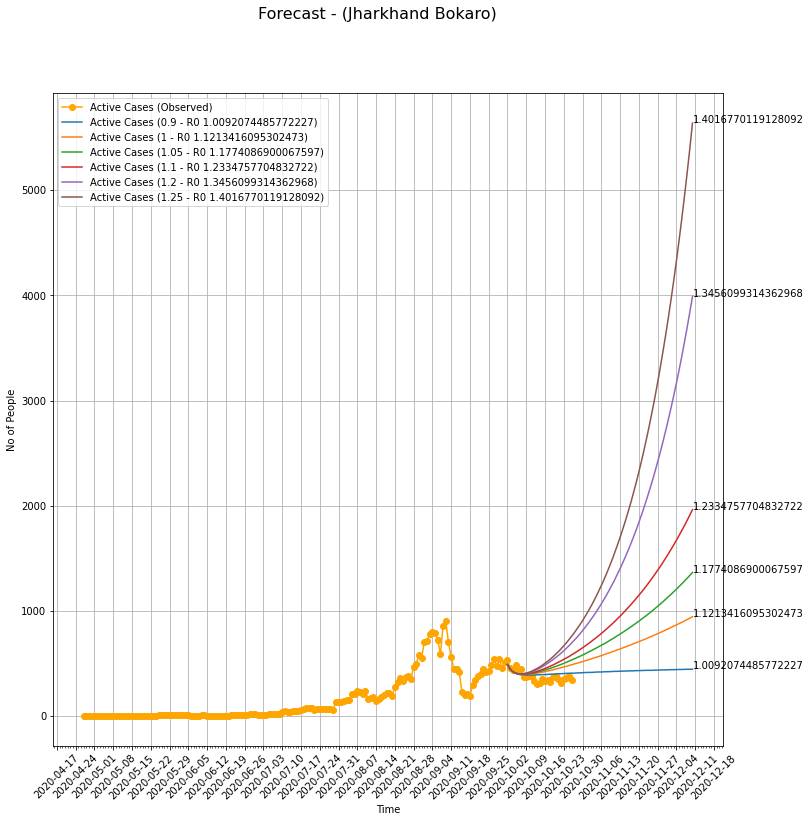

In [30]:
r0_mul_params= predictions_dict['m2']['deciles'][config['what_ifs']['percentile']]['params']
predictions_mul_dict = predict_r0_multipliers(predictions_dict, r0_mul_params, model=config['fitting']['model'],            days=config['forecast']['forecast_days'], multipliers=config['what_ifs']['multipliers'])
plot_r0_multipliers(predictions_dict, None, predictions_mul_dict, None, config['fitting']['data']['dataloading_params']['state'], config['fitting']['data']['dataloading_params']['district'])

## Create Report

In [31]:
save_dict_and_create_report(predictions_dict, config, ROOT_DIR=output_folder, config_filename=config_filename)

## Create Output

In [32]:
df_output = create_decile_csv_new(predictions_dict)
df_output.to_csv(f'{output_folder}/deciles.csv')

In [33]:
#log_wandb(predictions_dict)

## Create All Trials Output

In [34]:
df_all = create_all_trials_csv(predictions_dict)
df_all.to_csv(f'{output_folder}/all_trials.csv')

## Create R0 Multiplier Output

In [35]:
save_r0_mul(predictions_mul_dict, output_folder)

## Create df_district Output

In [36]:
predictions_dict['m1']['df_district'].to_csv(f'{output_folder}/df_district.csv')